# MNIST - fashion prediction

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

import matplotlib.pyplot as plt

load data  
this dataset download at $HOME/.keras/datasets

In [34]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [35]:
# copy data
train_X = train_images.copy()
train_y = train_labels.copy()
test_X = test_images.copy()
test_y = test_labels.copy()

## <u>EDA</u>

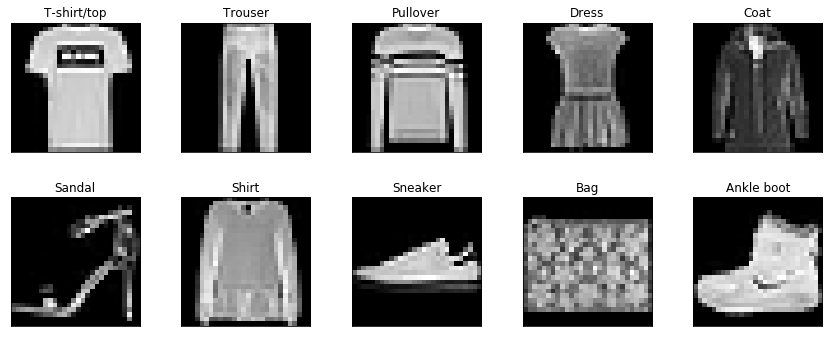

In [36]:
# 10개 카테고리 이미지 확인하기
def display_sample_img(X, y):
    category = { 0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
                 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
    fig, axes = plt.subplots(nrows=2, ncols=5)
    fig.set_size_inches(12,5)
    fig.tight_layout()
    num = 0
    for idx in range(2):
        for jdx in range(5):
            for index, label in enumerate(y):
                if label == num:
                    axes[idx][jdx].imshow(X[index], cmap='gray')
                    axes[idx][jdx].set_title(category[num])
                    axes[idx][jdx].set_xticks([])
                    axes[idx][jdx].set_yticks([])
                    num += 1
                    break

display_sample_img(train_X, train_y)

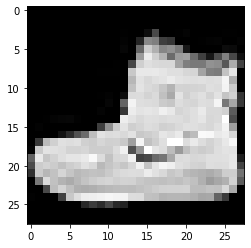

In [37]:
plt.imshow(train_X[0], cmap='gray')

## <u>preprocessing</u>

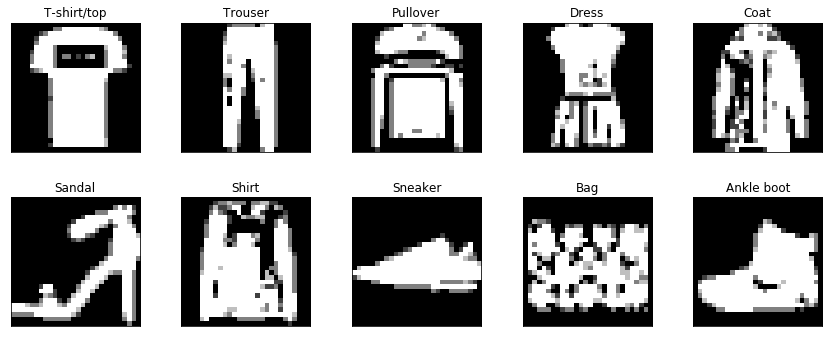

In [38]:
# 이미지 전처리 함수
def img_pipeline(img):
    import cv2
    img = cv2.resize(img, dsize=(0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR) # 확대
    img = cv2.equalizeHist(img) # 평활화
    ret,img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # 이진화
    img = cv2.resize(img, dsize=(0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR) # 축소
    return img

# 적용
train = []
test = []
for img in train_X:
    train.append(img_pipeline(img))
for img in test_X:
    test.append(img_pipeline(img))    
train_X, test_X = train.copy(), test.copy()

# 확인
display_sample_img(train_X, train_y)

In [39]:
np.array(train_X).shape

(60000, 28, 28)

In [7]:
def ohe(ndarr):
    res = []
    for idx in ndarr:
        ohe_arr = [0]*10
        ohe_arr[idx[0]] = 1
        res.append(ohe_arr)
    return np.array(res)

# one-hot-encoding
train_y = ohe(train_y.reshape(-1,1))
test_y = ohe(test_y.reshape(-1,1))

# reshape (?,56*56)
train_X = np.array(train_X)
test_X = np.array(test_X)
train_X = train_X.reshape(len(train_X),-1)
test_X = test_X.reshape(len(test_X),-1)

# normalization
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
train_X = ss.fit_transform(train_X)
test_X = ss.fit_transform(test_X)

In [8]:
test_y.shape

(10000, 10)

## <u>modelling</u>

In [20]:
fashion_classes = 10
learning_rate = 0.01

tf.reset_default_graph() #그래프에 있는 모든 텐서를 초기화
x=tf.placeholder(tf.float32, [None,28*28])
y=tf.placeholder(tf.float32, [None,10])

keep_prob=tf.placeholder(tf.float32)

w1=tf.get_variable("w1", shape=[28*28,128],initializer=tf.contrib.layers.xavier_initializer())
b1=tf.Variable(tf.random_normal([128]))
L1=tf.nn.relu(tf.matmul(x,w1)+b1)
L1=tf.nn.dropout(L1, keep_prob=keep_prob)

w2=tf.get_variable("w2", shape=[128,128],initializer=tf.contrib.layers.xavier_initializer())
b2=tf.Variable(tf.random_normal([128]))
L2=tf.nn.relu(tf.matmul(L1,w2)+b2)
L2=tf.nn.dropout(L2, keep_prob=keep_prob)


w3=tf.get_variable("w3", shape=[128,128],initializer=tf.contrib.layers.xavier_initializer())
b3=tf.Variable(tf.random_normal([128]))
L3=tf.nn.relu(tf.matmul(L2,w3)+b3)
L3=tf.nn.dropout(L3, keep_prob=keep_prob)


w4=tf.get_variable("w4", shape=[128,128],initializer=tf.contrib.layers.xavier_initializer())
b4=tf.Variable(tf.random_normal([128]))
L4=tf.nn.relu(tf.matmul(L3,w4)+b4)
L4=tf.nn.dropout(L4, keep_prob=keep_prob)


w5=tf.get_variable("w5", shape=[128,10],initializer=tf.contrib.layers.xavier_initializer())
b5=tf.Variable(tf.random_normal([10]))
hf=tf.matmul(L4,w5)+b5

cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
               (logits=hf, labels=y))
train=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

is_correct=tf.equal(tf.argmax(hf,1), tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(is_correct, tf.float32))

Epoch:     1 cost:  0.902851098
Epoch:     2 cost:  1.904535801
learning finished
accuracy:  0.2459
Label:  [0]
Prediction:  [7]


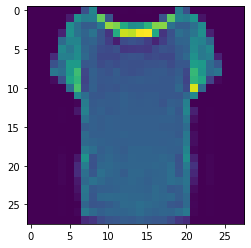

In [19]:
trainin_epochs = 2
batch_size = 100
idx = 0
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(trainin_epochs):
        avg_cost = 0
        total_batch = int(train_X.shape[0] / batch_size)
        
        for _ in range(total_batch):
            batch_xs = train_X[idx:idx+batch_size]
            batch_ys = train_y[idx:idx+batch_size]
            myfeed={x:batch_xs, y:batch_ys, keep_prob:0.7}
            cv, _ = sess.run([cost, train], feed_dict=myfeed)
            avg_cost += cv/total_batch
        idx += batch_size
            
        print('Epoch: ', '%4d'%(epoch+1),
              'cost: ', '{:.9f}'.format(avg_cost))
    print('learning finished')
    print('accuracy: ', sess.run(accuracy, feed_dict={x:test_X, y:test_y, keep_prob:1}))

    import random
    r = random.randint(0, len(test_images)-1)
    print('Label: ', sess.run(tf.argmax(test_y[r:r+1], 1)))
    print('Prediction: ', sess.run(tf.argmax(hf,1), feed_dict={x:test_X[r:r+1], keep_prob:1}))
    plt.imshow(test_images[r:r+1].reshape(28,28))
    plt.show()